In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout


In [2]:
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')

In [3]:
dataset_train.head()

Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800

In [4]:
#keras only takes numpy array
training_set = dataset_train.iloc[:, 1: 2].values


In [5]:
training_set.shape

(1258, 1)

In [6]:
sc = MinMaxScaler(feature_range = (0, 1))
#fit: get min/max of train data
training_set_scaled = sc.fit_transform(training_set)

In [7]:
## 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
 X_train.append(training_set_scaled[i-60: i, 0])
 y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [8]:
X_train.shape


(1198, 60)

In [9]:
y_train.shape

(1198,)

In [10]:
X_train = np.reshape(X_train, newshape = (X_train.shape[0], X_train.shape[1], 1))

In [11]:
X_train.shape

(1198, 60, 1)

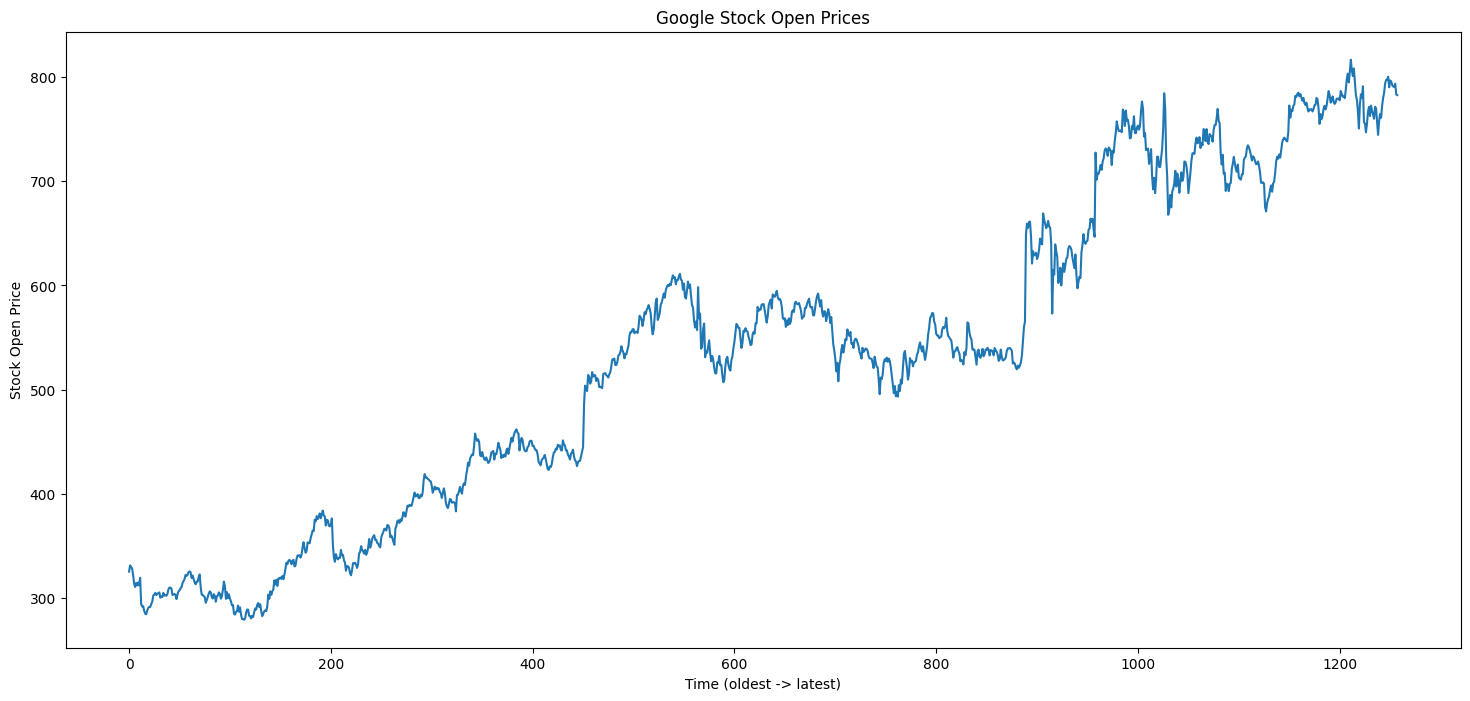

In [12]:

plt.figure(figsize=(18, 8))
plt.plot(dataset_train['Open'])
plt.title("Google Stock Open Prices")
plt.xlabel("Time (oldest -> latest)")
plt.ylabel("Stock Open Price")
plt.show()

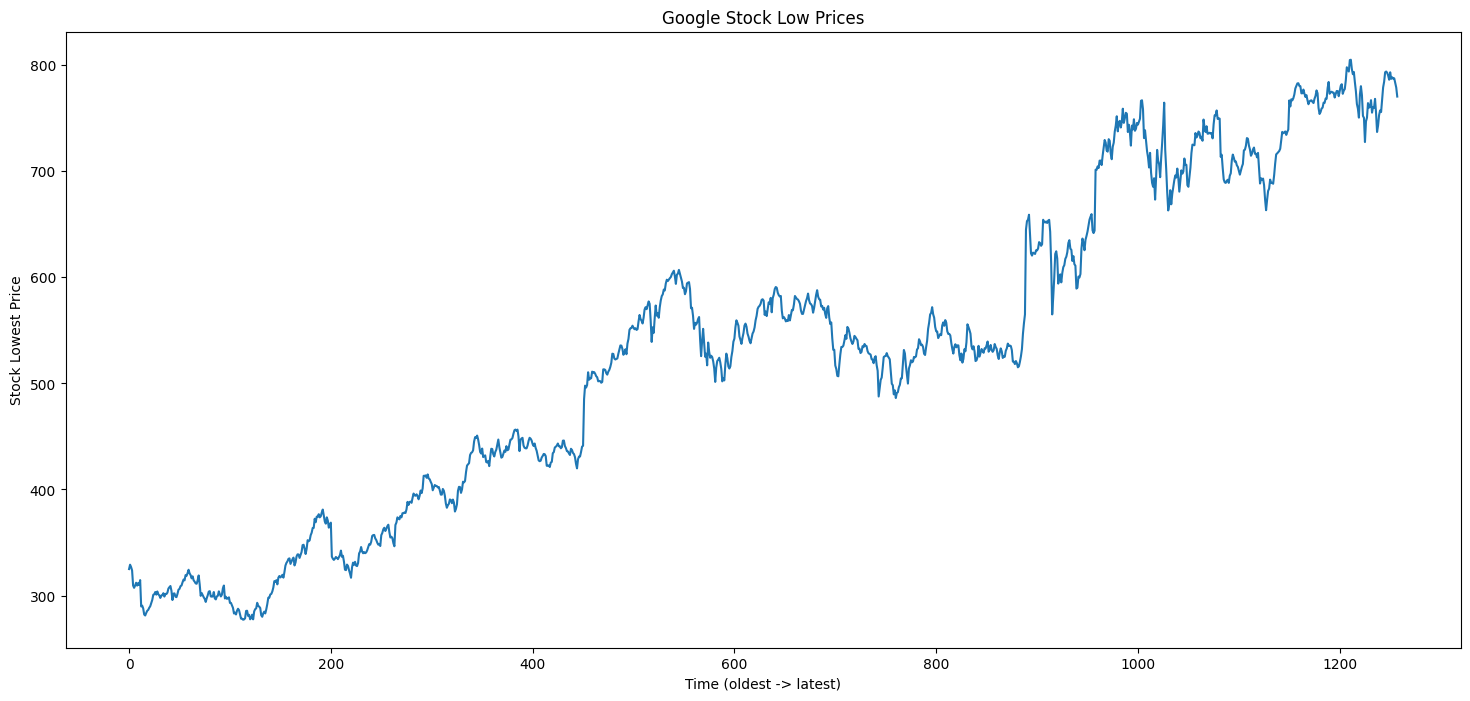

In [13]:
plt.figure(figsize=(18, 8))
plt.plot(dataset_train['Low'])
plt.title("Google Stock Low Prices")
plt.xlabel("Time (oldest -> latest)")
plt.ylabel("Stock Lowest Price")
plt.show()

In [14]:
regressor = Sequential()
#add 1st lstm layer
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(rate = 0.2))
##add 2nd lstm layer: 50 neurons
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))
##add 3rd lstm layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))
##add 4th lstm layer
regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(rate = 0.2))
##add output layer
regressor.add(Dense(units = 1))

In [15]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [30]:
regressor.fit(x = X_train, y = y_train, batch_size = 32, epochs = 100)

Epoch 1/100
38/38 [==============================] - 3s 73ms/step - loss: 0.0043
Epoch 2/100
38/38 [==============================] - 3s 71ms/step - loss: 0.0037
Epoch 3/100
38/38 [==============================] - 3s 72ms/step - loss: 0.0036
Epoch 4/100
38/38 [==============================] - 3s 73ms/step - loss: 0.0036
Epoch 5/100
38/38 [==============================] - 3s 71ms/step - loss: 0.0036
Epoch 6/100
38/38 [==============================] - 3s 72ms/step - loss: 0.0035
Epoch 7/100
38/38 [==============================] - 3s 71ms/step - loss: 0.0030
Epoch 8/100
38/38 [==============================] - 3s 70ms/step - loss: 0.0029
Epoch 9/100
38/38 [==============================] - 3s 74ms/step - loss: 0.0034
Epoch 10/100
38/38 [==============================] - 3s 67ms/step - loss: 0.0032
Epoch 11/100
38/38 [==============================] - 3s 73ms/step - loss: 0.0031
Epoch 12/100
38/38 [==============================] - 3s 72ms/step - loss: 0.0029
Epoch 13/100
38/38 [=====

In [31]:
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')

In [32]:
dataset_test.head()

Date    Open    High     Low   Close     Volume
0  1/3/2017  778.81  789.63  775.80  786.14  1,657,300
1  1/4/2017  788.36  791.34  783.16  786.90  1,073,000
2  1/5/2017  786.08  794.48  785.02  794.02  1,335,200
3  1/6/2017  795.26  807.90  792.20  806.15  1,640,200
4  1/9/2017  806.40  809.97  802.83  806.65  1,272,400

In [33]:
#keras only takes numpy array
real_stock_price = dataset_test.iloc[:, 1: 2].values
real_stock_price.shape

(20, 1)

In [34]:
#vertical concat use 0, horizontal uses 1
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']),
 axis = 0)
##use .values to make numpy array
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values


In [35]:
#reshape data to only have 1 col
inputs = inputs.reshape(-1, 1)
#scale input
inputs = sc.transform(inputs)
len(inputs)

80

In [36]:
X_test = []
for i in range(60, len(inputs)):
 X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
#add dimension of indicator
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [37]:
X_test.shape

(20, 60, 1)

In [38]:
predicted_stock_price = regressor.predict(X_test)

1/1 [==============================] - 0s 55ms/step


In [39]:
#inverse the scaled value
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

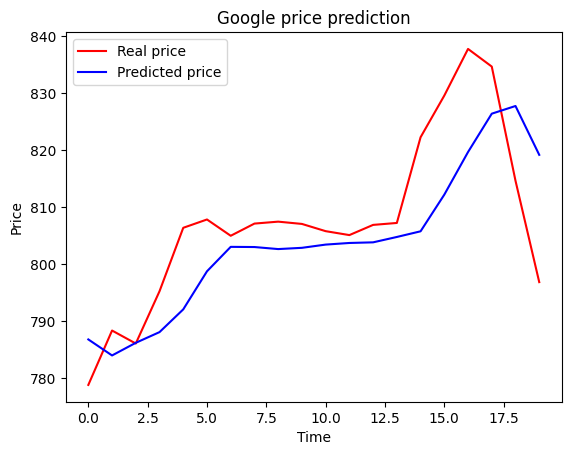

In [40]:
##visualize the prediction and real price
plt.plot(real_stock_price, color = 'red', label = 'Real price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted price')
plt.title('Google price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()